<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/main/Labs/lab09_WENDy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9: data-driven system identification
We'll take the same setup as lab 8, looking at the logistic differential equation
$$dy/dt = \theta y \left( 1 - y/k \right)$$
for a carrying capacity $k=10$, initial condition $y(0) = y_0 = 1$, and an **unknown** growth rate $\theta$.

We assume that we have some (slightly noisy) observations $\{(t_i,y(t_i))\}_{i=1}^n$ of the true solution. From these observations, the goal is to estimate the growth rate $\theta$.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.integrate import solve_ivp, trapezoid

import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp

## Part 1: generate the data
Solve the logistic ODE on the domain $[0,T=3]$ using $y_0=1$, $k=10$ and $\theta=\pi$.

From the solution collect `n_obs=21` observations $\{(t_i,y(t_i))\}_{i=1}^{n_\text{obs}}$ from an equispaced time grid (later you can try adjusting `n_obs` to smaller/larger values), and add some Gaussian noise of standard deviation $0.01$ (again, later you can try adjusting the amount of noise)

In [ ]:
rng = np.random.default_rng(123456)
karryingKapacity = 10 # carrying capacity, a fixed parameter

def f(t,y,theta):
    """ Logistic equation right-hand-side
    dy/dt = theta y (1-y/k),  y(t) is the population, theta is growth rate parameter, k is karrying kapacity
    """
    return theta*y*(1.-y/karryingKapacity)

y0 = 1. # Starting value

theta_true = np.pi # true value... (different than last week)
theta = theta_true

T  = 3.
t_span = (0,T)

soln = solve_ivp( ... TODO ... )

n_obs = 21
t_obs = np.linspace(0,T,n_obs)
y_obs = ... TODO ...
# add a small amount of noise
sigma = 0.01
y_obs = y_obs + sigma*rng.standard_normal(y_obs.shape)

# Plot the solution if you want...

## Part 2: solve with SINDy

[Sparse identification of non-linear dynamics](https://en.wikipedia.org/wiki/Sparse_identification_of_non-linear_dynamics) ("SINDy") is one of several methods that estimates an equation from data, i.e., to estimate $y' = f(t,y)$.  You give it a dictionary of candidate terms that will comprise the RHS $f$ and it will estimate which ones are "active" (the "sparse" part) and then find their coefficient.

We'll do a simplified setting: we know that $f(t,y)$ is of the form $y(1-y/k)$ but we just don't know the coefficient. So the idea is very simple: collect observations $y'(t_i)$ and RHS $y(t_i)(1-y(t_i)/k)$ for $\{t_i\}_{i=1}^{n_\text{obs}}$ and then do a least-squares regression.

The only issue is how do we know $y'(t_i)$ given that our data is $\{(t_i,y(t_i))\}_{i=1}^{n_\text{obs}}$?

The quick-and-dirty answer is to approximate it with finite differences.

## Part 2a: write a finite difference routine
Give a data vector of equally spaced points $y(t_i)$, and a spacing parameter $\Delta t$ (where $t_i = \Delta t + t_{i-1}$), right a routine that returns a finite difference approximation of $dy/dt$ at these same time points.

You can do a simple version (forward finite differences) or something higher order like centered differences (see my [Ch4_FiniteDifference Notes](https://github.com/stephenbeckr/numerical-analysis-class/blob/master/Notes/Ch4_FiniteDifferences_more.pdf) from undergrad numerical analysis for ideas on how to handle the first/last node)

You can test your code because in our academic setting we actually know $y'$ (since we know the ODE exactly!)

In [12]:
def myFiniteDifferences(y,dt):
    """ finite difference approximation of derivative from discrete points y(t)
    """
    # TODO: implement this yourself
    raise NotImplementedError

# Helper function for later
def myLeastSquares(A,b):
    return np.linalg.lstsq(A.reshape(-1,1),b,rcond=None)[0][0]

In [ ]:
# Is the finite difference a good approximation? We know the true derivative, so we can check
dt = t_obs[1]-t_obs[0]

approx_dydt = myFiniteDifferences(y_obs,dt)
true_dydt  = f(t_obs,y_obs,theta_true)

approx_dydt - true_dydt

## Part 2b: find the coefficient, SINDy style

Now regress, and find the coefficient. Compare it to the true coefficient

In [ ]:
dydt = myFiniteDifferences(y_obs,dt)

# Regress dydt = theta*y*(1-y/k)
A   = ... TODO ...
theta_SINDy = myLeastSquares(A,dydt)

print(f'Using {len(t_obs)} points, {theta_SINDy=:.6f} while {theta_true=:.6f}')
print(f'Noise was {sigma=:.3f}')

## Part 2: Weak form (WENDy style)
An alternative approach to avoid the finite difference calculation (since that won't be accurate if $\Delta t$ is large or if there is a lot of noise $\sigma$) is to use the weak form.  In the case of just estimating a coefficient, this is described in the "WENDy" paper [Direct Estimation of Parameters in ODE Models Using WENDy: Weak-form Estimation of Nonlinear Dynamics](https://arxiv.org/abs/2302.13271) 2023 by CU Applied Math dept authors David Bortz, Daniel A. Messenger, Vanja Dukic.

The main idea is that we will create a library of test functions $\{\varphi_j\}_{j=1}^{n_\text{test}}$ that are smooth and vanish on the boundaries of the interval $[0,T]$ and do a lot of integration by parts.  We defin the inner product $\langle f, g \rangle := \int_0^T f(t) g(t)dt$, so the integration-by-parts trick is that
$$ \langle \varphi, y' \rangle := \int_0^T \varphi(t)y'(t)dt
= \varphi(t)y(t)\Big|_{t=0}^T - \int_0^T \varphi'(t)y(t)dt = -\langle \varphi', y\rangle.
$$

So consider the ODE $y' = \theta y (1-y/k)$. Then it's also true that for every test function,
$$\langle \varphi, y'\rangle = \theta \langle \varphi, y(1-y/k)\rangle$$
so using our integration-by-parts trick, this means
$$-\langle \varphi', y\rangle = \theta \langle \varphi, y(1-y/k)\rangle.$$

We choose $\varphi$ (e.g., with a formula) so we know $\varphi'$ (we'll use `jax`'s autodiff). We then need to estimate these **integrals** from the data instead of estimating **derivatives**.  We can use a default quadrature routine for the integrals, e.g., `scipy.integrate.trapezoid`.

So now we do this for a few test functions $\varphi_j$ and then solve a least-squares equation to estimate $\theta$.

We'll do some simple test functions; see the WENDy paper for more advanced ideas (and efficient implementations with the FFT)

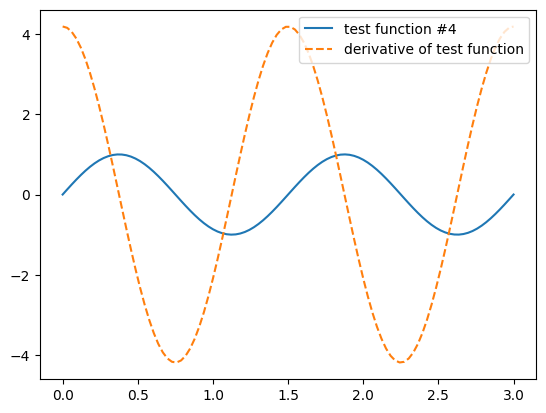

In [6]:
def phi(t,mode):
    """ mode>0 an integer """
    return jnp.sin(mode*jnp.pi*t/T)
dphi  = jax.vmap(jax.grad(phi,argnums=0), in_axes=(0,None))


mode = 4
tGrid = jnp.linspace(0,T,100)
plt.plot( tGrid, phi(tGrid,mode), label=f'test function #{mode}' )
plt.plot( tGrid, dphi(tGrid,mode),'--', label='derivative of test function' )
plt.legend()
plt.show()

## Part 2a: integrals
For any test function $\varphi$,
1. estimate $\langle \varphi, y'\rangle$ using the data.  (We don't directly have data for $y'$, but for now you can cheat and use the fact that we know the ODE exactly)
2. estimate -$\langle \varphi', y\rangle$ using the data (this we **can** do from the data directly).
3. are the above two quantities about the same?

Use `trapezoid` for the [quadrature](https://en.wikipedia.org/wiki/Numerical_integration)

In [ ]:
mode = 4

lhs = phi(t_obs,mode)
rhs = ... ? ...   # the true derivative (cheating)
integral_1 = trapezoid( lhs * rhs, t_obs)

lhs = ... ? ...
rhs = ... ? ...
integral_2 = ... ? ...

print(f'{integral_1=:.3f}')
print(f'{integral_2=:.3f}')

## Part 2b: solve for $\theta$ via the WENDy approach

In [ ]:
# Setup WENDy
modeList = np.arange(1,19 ) # choose modes 1 -- 18
A   = np.zeros( (len(modeList),1))
RHS = np.zeros( len(modeList) )
for (i,mode) in enumerate(modeList):
    RHS[i] = ... ? ...
    A[i]   = ... ? ...

theta_WENDy = myLeastSquares(A,RHS)

print(f'Using {len(t_obs)} points, ...')
print(f' {theta_SINDy=:.6f}')
print(f' {theta_WENDy=:.6f}')
print(f'  {theta_true=:.6f}')
print(f'Noise was {sigma=:.3f}')